# 在拆分学习中使用通讯压缩方法

> 以下代码仅作为示例，请勿在生产环境直接使用。

> 本示例基于基于“拆分学习：银行营销”教程制作，建议先观看那个教程。

在拆分学习中，由于模型被拆分在多个设备当中，进行训练的时候，各方需要对特征和梯度进行多次传输，带来很高的网络通讯消耗。为了减少通讯过程中的数据量，可以进行一些压缩处理。

SecretFlow提供了Compressor对拆分学习中的数据进行压缩。同时也提供了多种基类，可以在此基础上实现自己的压缩算法。

下面我们来试试一些算法的可用性，首先，我们在secretflow环境中创造2个实体alice和bob。

In [1]:
import secretflow as sf

sf.shutdown()
sf.init(['alice', 'bob'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')

2023-08-09 07:25:20,525	WARNING services.py:1732 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.38gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-08-09 07:25:20,715	INFO worker.py:1538 -- Started a local Ray instance.


接下来我们准备要学习的数据。

我们使用“拆分学习：银行营销”中的数据准备和处理方法，下载银行营销数据集并进行处理。alice和bob的角色和之前的教程完全相同：

In [2]:
from secretflow.utils.simulation.datasets import load_bank_marketing
from secretflow.preprocessing.scaler import MinMaxScaler
from secretflow.preprocessing.encoder import LabelEncoder
from secretflow.data.split import train_test_split

random_state = 1234

data = load_bank_marketing(parts={alice: (0, 4), bob: (4, 16)}, axis=1)
label = load_bank_marketing(parts={alice: (16, 17)}, axis=1)

encoder = LabelEncoder()
data['job'] = encoder.fit_transform(data['job'])
data['marital'] = encoder.fit_transform(data['marital'])
data['education'] = encoder.fit_transform(data['education'])
data['default'] = encoder.fit_transform(data['default'])
data['housing'] = encoder.fit_transform(data['housing'])
data['loan'] = encoder.fit_transform(data['loan'])
data['contact'] = encoder.fit_transform(data['contact'])
data['poutcome'] = encoder.fit_transform(data['poutcome'])
data['month'] = encoder.fit_transform(data['month'])
label = encoder.fit_transform(label)

scaler = MinMaxScaler()
data = scaler.fit_transform(data)

train_data,test_data = train_test_split(data, train_size=0.8, random_state=random_state)
train_label,test_label = train_test_split(label, train_size=0.8, random_state=random_state)

(_run pid=6435) /usr/local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
(_run pid=6435)   warnings.warn(
(_run pid=6435) /usr/local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
(_run pid=6435)   warnings.warn(


接下来我们创建联邦模型，同样地，我们使用“拆分学习：银行营销”中的建模，构建出base_model和fuse_model，然后就可以定义SLModel用于训练：

In [3]:
def create_base_model(input_dim, output_dim,  name='base_model'):
    # Create model
    def create_model():
        from tensorflow import keras
        from tensorflow.keras import layers
        import tensorflow as tf
        model = keras.Sequential(
            [
                keras.Input(shape=input_dim),
                layers.Dense(100,activation ="relu" ),
                layers.Dense(output_dim, activation="relu"),
            ]
        )
        # Compile model
        model.summary()
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=["accuracy",tf.keras.metrics.AUC()])
        return model
    return create_model

# prepare model
hidden_size = 64

model_base_alice = create_base_model(4, hidden_size)
model_base_bob = create_base_model(12, hidden_size)

def create_fuse_model(input_dim, output_dim, party_nums, name='fuse_model'):
    def create_model():
        from tensorflow import keras
        from tensorflow.keras import layers
        import tensorflow as tf
        # input
        input_layers = []
        for i in range(party_nums):
            input_layers.append(keras.Input(input_dim,))

        merged_layer = layers.concatenate(input_layers)
        fuse_layer = layers.Dense(64, activation='relu')(merged_layer)
        output = layers.Dense(output_dim, activation='sigmoid')(fuse_layer)

        model = keras.Model(inputs=input_layers, outputs=output)
        model.summary()

        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=["accuracy",tf.keras.metrics.AUC()])
        return model
    return create_model

model_fuse = create_fuse_model(
    input_dim=hidden_size, party_nums=2, output_dim=1)

base_model_dict = {
    alice: model_base_alice,
    bob:   model_base_bob
}



from secretflow.ml.nn import SLModel
sl_model_origin = SLModel(
    base_model_dict=base_model_dict,
    device_y=alice,
    model_fuse=model_fuse,
    )

2023-08-09 07:25:24.883751: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-09 07:25:25.668704: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-09 07:25:25.668815: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-09 07:25:25.668825: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

### 使用通讯压缩算法

SecretFlow提供了Compressor，里面实现了各种基础的通讯压缩算法，可以直接使用。

只要导入想使用的压缩算法并实例化,定义SLModel时将实例化的方法作为参数传入就可以在训练中实现通讯压缩。

我们以QuantizedFP为例，该算法会将浮点数量化到8位以降低传输消耗。

In [4]:
from secretflow.utils.compressor import QuantizedFP

qfp = QuantizedFP()

sl_model_compress = SLModel(
    base_model_dict=base_model_dict,
    device_y=alice,
    model_fuse=model_fuse,
    compressor = qfp    #在这里传入实例化的compressor算法
    )


INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.tensorflow.sl_base.PYUSLTFModel'> with party alice.


INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.tensorflow.sl_base.PYUSLTFModel'> with party bob.


我们分别对没有使用通讯压缩的模型和使用了量化压缩的模型进行训练，并把训练轮次拉高到40轮，看看效果如何。

In [5]:
histories = []
for sl_model in [sl_model_origin, sl_model_compress]:

    history = sl_model.fit(train_data,
            train_label,
            validation_data=(test_data,test_label),
            epochs=40,
            batch_size=128,
            shuffle=True,
            verbose=1,
            validation_freq=1,
            )
    
    histories.append(history)

INFO:root:SL Train Params: {'x': VDataFrame(partitions={PYURuntime(alice): Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7fb8a048f850>), PYURuntime(bob): Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7fb8a0be21f0>)}, aligned=True), 'y': VDataFrame(partitions={PYURuntime(alice): Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7fb8a048f910>)}, aligned=True), 'batch_size': 128, 'epochs': 40, 'verbose': 1, 'callbacks': None, 'validation_data': (VDataFrame(partitions={PYURuntime(alice): Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7fb8a048fc10>), PYURuntime(bob): Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7fb8a0478ac0>)}, aligned=True), VDataFrame(partitions={PYURuntime(alice): Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7fb8a048f280>)}, aligned=True)), 'shuffle': True, 'sample_weight': None, 'validation_freq': 1, 'dp_spent_step_freq': None, 'dataset_builder': No

(PYUSLTFModel pid=7216) Model: "sequential"
(PYUSLTFModel pid=7216) _________________________________________________________________
(PYUSLTFModel pid=7216)  Layer (type)                Output Shape              Param #   
(PYUSLTFModel pid=7216) =================================================================
(PYUSLTFModel pid=7216)  dense (Dense)               (None, 100)               500       
(PYUSLTFModel pid=7216)                                                                  
(PYUSLTFModel pid=7216)  dense_1 (Dense)             (None, 64)                6464      
(PYUSLTFModel pid=7216)                                                                  
(PYUSLTFModel pid=7216) =================================================================
(PYUSLTFModel pid=7216) Total params: 6,964
(PYUSLTFModel pid=7216) Trainable params: 6,964
(PYUSLTFModel pid=7216) Non-trainable params: 0
(PYUSLTFModel pid=7216) _________________________________________________________________
(PYUSL

(PYUSLTFModel pid=7229) 2023-08-09 07:25:32.926538: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
(PYUSLTFModel pid=7229) 2023-08-09 07:25:32.926589: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


(PYUSLTFModel pid=7229) Model: "sequential"
(PYUSLTFModel pid=7229) _________________________________________________________________
(PYUSLTFModel pid=7229)  Layer (type)                Output Shape              Param #   
(PYUSLTFModel pid=7229) =================================================================
(PYUSLTFModel pid=7229)  dense (Dense)               (None, 100)               1300      
(PYUSLTFModel pid=7229)                                                                  
(PYUSLTFModel pid=7229)  dense_1 (Dense)             (None, 64)                6464      
(PYUSLTFModel pid=7229)                                                                  
(PYUSLTFModel pid=7229) =================================================================
(PYUSLTFModel pid=7229) Total params: 7,764
(PYUSLTFModel pid=7229) Trainable params: 7,764
(PYUSLTFModel pid=7229) Non-trainable params: 0
(PYUSLTFModel pid=7229) _________________________________________________________________


  0%|          | 0/29 [00:00<?, ?it/s](PYUSLTFModel pid=7242) 2023-08-09 07:25:33.136230: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
(PYUSLTFModel pid=7242) 2023-08-09 07:25:33.136275: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
(PYUSLTFModel pid=7327) 2023-08-09 07:25:33.275542: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
(PYUSLTFModel pid=7327) 2023-08-09 07:25:33.275581: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


(PYUSLTFModel pid=7242) Model: "sequential"
(PYUSLTFModel pid=7242) _________________________________________________________________
(PYUSLTFModel pid=7242)  Layer (type)                Output Shape              Param #   
(PYUSLTFModel pid=7242) =================================================================
(PYUSLTFModel pid=7242)  dense (Dense)               (None, 100)               500       
(PYUSLTFModel pid=7242)                                                                  
(PYUSLTFModel pid=7242)  dense_1 (Dense)             (None, 64)                6464      
(PYUSLTFModel pid=7242)                                                                  
(PYUSLTFModel pid=7242) =================================================================
(PYUSLTFModel pid=7242) Total params: 6,964
(PYUSLTFModel pid=7242) Trainable params: 6,964
(PYUSLTFModel pid=7242) Non-trainable params: 0
(PYUSLTFModel pid=7242) _________________________________________________________________
(PYUSL

2023-08-09 07:25:34.200179: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-09 07:25:34.200224: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
  7%|▋         | 2/29 [00:01<00:15,  1.76it/s](_run pid=6438) 2023-08-09 07:25:34.506452: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(_run pid=6438) 2023-08-09 07:25:35.200074: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
(_run pid=6438) 2023-08-09 07:25:35.200296: W tensorflow/compiler/xla

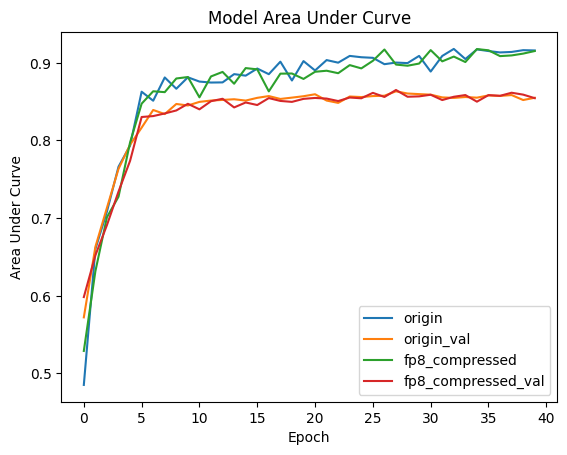

In [6]:
import matplotlib.pyplot as plt

for history in histories:
    plt.plot(history['train_auc_1'])
    plt.plot(history['val_auc_1'])

plt.title('Model Area Under Curve')
plt.ylabel('Area Under Curve')
plt.xlabel('Epoch')
plt.legend(['origin', 'origin_val', 'fp8_compressed', 'fp8_compressed_val'], loc='lower right')
plt.show()

可以看到，两个模型的验证集auc均在0.85左右波动，使用8位量化对此任务的训练精度影响不大，而理论通讯消耗减少了3/4（从32位减少到了8位）。



### 自定义通讯压缩算法

我们也可以自定义一个压缩算法，SecretFlow提供了SparseCompressor和QuantizedCompressor基类，对应稀疏化方法和量化压缩方法。

这里以量化压缩方法为例，来实现一个基于K-means的压缩算法。

K-means压缩论文是"Deep Compression: Compressing Deep Neural Networks with Pruning, Trained Quantization and Huffman Coding"提出的方法中的其中一个步骤，其思想是把对传输参数进行聚类，保存聚类中心的值，然后把其他值用聚类序号来表示。

继承QuantizedCompressor后，只要实现_compress_one（将一个numpy向量打包为QuantizedData） 和 _decompress_one（将QuantizedData还原回numpy向量）函数即可。

In [7]:
from secretflow.utils.compressor import QuantizedCompressor, QuantizedData
import numpy as np

class QuantizedKmeans(QuantizedCompressor):

    def __init__(self, quant_bits: int = 8):
        super().__init__(quant_bits)
        from sklearn.cluster import KMeans
        self.km = KMeans(2**quant_bits, n_init=1, max_iter=50)

    def _compress_one(self, data: np.ndarray) -> QuantizedData:
        ori_shape = data.shape
        self.km.fit(np.expand_dims(data.flatten(), axis=1))
        quantized = self.km.labels_ - (1 << (self.quant_bits - 1))
        quantized = np.reshape(quantized, ori_shape)
        q = self.km.cluster_centers_

        return QuantizedData(quantized.astype(self.np_type), q, None, data.dtype)

    def _decompress_one(self, data: QuantizedData) -> np.ndarray:
        label = data.data.astype(data.origin_type) + (1 << (self.quant_bits - 1))
        dequantized = np.zeros_like(label)
        for i in range(data.q1.shape[0]):
            dequantized[label == i] = data.q1[i]

        return dequantized

我们来实例化这个算法，再跑一遍联邦学习模型：

In [8]:
qkm = QuantizedKmeans()

sl_model_kmeans = SLModel(
    base_model_dict=base_model_dict,
    device_y=alice,
    model_fuse=model_fuse,
    compressor=qkm,
    )

history_kmeans = sl_model_kmeans.fit(train_data,
            train_label,
            validation_data=(test_data,test_label),
            epochs=40,
            batch_size=128,
            shuffle=True,
            verbose=1,
            validation_freq=1,
            )

INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.tensorflow.sl_base.PYUSLTFModel'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.tensorflow.sl_base.PYUSLTFModel'> with party bob.
INFO:root:SL Train Params: {'x': VDataFrame(partitions={PYURuntime(alice): Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7fb8a048f850>), PYURuntime(bob): Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7fb8a0be21f0>)}, aligned=True), 'y': VDataFrame(partitions={PYURuntime(alice): Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7fb8a048f910>)}, aligned=True), 'batch_size': 128, 'epochs': 40, 'verbose': 1, 'callbacks': None, 'validation_data': (VDataFrame(partitions={PYURuntime(alice): Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7fb8a048fc10>), PYURuntime(bob): Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7fb8a0478ac0>)}, aligned=True), VDataFrame(partitions

(PYUSLTFModel pid=9318) Model: "sequential"
(PYUSLTFModel pid=9318) _________________________________________________________________
(PYUSLTFModel pid=9318)  Layer (type)                Output Shape              Param #   
(PYUSLTFModel pid=9318) =================================================================
(PYUSLTFModel pid=9318)  dense (Dense)               (None, 100)               500       
(PYUSLTFModel pid=9318)                                                                  
(PYUSLTFModel pid=9318)  dense_1 (Dense)             (None, 64)                6464      
(PYUSLTFModel pid=9318)                                                                  
(PYUSLTFModel pid=9318) =================================================================
(PYUSLTFModel pid=9318) Total params: 6,964
(PYUSLTFModel pid=9318) Trainable params: 6,964
(PYUSLTFModel pid=9318) Non-trainable params: 0
(PYUSLTFModel pid=9318) _________________________________________________________________
(PYUSL

100%|██████████| 29/29 [00:13<00:00,  2.08it/s, epoch: 40/40 -  train_loss:0.21099236607551575  train_accuracy:0.9140625  train_auc_1:0.9125713109970093  val_loss:0.2784137725830078  val_accuracy:0.8817679286003113  val_auc_1:0.8655475378036499 ]


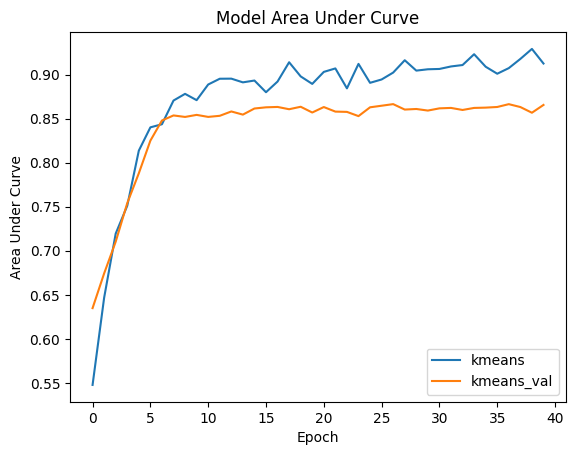

In [9]:
plt.plot(history_kmeans['train_auc_1'])
plt.plot(history_kmeans['val_auc_1'])

plt.title('Model Area Under Curve')
plt.ylabel('Area Under Curve')
plt.xlabel('Epoch')
plt.legend(['kmeans','kmeans_val'], loc='lower right')
plt.show()

最终验证集auc在0.865左右，也还不错~

### 总结

本篇示例介绍了通讯压缩算法，并在拆分学习的基础之上使用了SecretFlow提供和自行设计的压缩算法。

从实验数据可以看出，将32位数压缩为8位的精度损失不大，而理论通信消耗仅为不作压缩时的1/4，因此在需要频繁传输数据和梯度的拆分学习中，加入通讯压缩不失为一个好的选择。

本教程使用明文聚合来做演示，同时没有考虑隐藏层的泄露问题，SecretFlow提供了聚合层AggLayer，通过MPC,TEE,HE，以及DP等方式规避隐层明文传输泄露的问题。如果您感兴趣，可以看相关文档。